In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
covid19_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid19_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid19_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [3]:
covid19_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


##### Is Any Missing Data?

In [4]:
covid19_confirmed.isnull().sum()

Province/State    198
Country/Region      0
Lat                 2
Long                2
1/22/20             0
                 ... 
3/5/23              0
3/6/23              0
3/7/23              0
3/8/23              0
3/9/23              0
Length: 1147, dtype: int64

#### Data Processing

In [5]:
confirmed_world = covid19_confirmed.drop(['Province/State','Lat','Long'], axis = 1)
confirmed_world = confirmed_world.groupby(['Country/Region']).sum()

In [6]:
deaths_world = covid19_deaths.drop(['Province/State','Lat','Long'], axis = 1)
deaths_world = deaths_world.groupby(['Country/Region']).sum()

In [7]:
recovered_world = covid19_recovered.drop(['Province/State','Lat','Long'], axis = 1)
recovered_world = recovered_world.groupby(['Country/Region']).sum()

In [8]:
DF_World = pd.DataFrame(confirmed_world[:].sum(), columns = ['Confirmed'])

In [9]:
DF_World['Deaths'] = pd.DataFrame(deaths_world[:].sum())

In [10]:
DF_World['Recovered'] = pd.DataFrame(recovered_world[:].sum())

In [11]:
DF_World

,Confirmed,Deaths,Recovered
1/22/20,557,17,30
1/23/20,657,18,32
1/24/20,944,26,39
1/25/20,1437,42,42
1/26/20,2120,56,56
...,...,...,...
3/5/23,676024901,6877749,0
3/6/23,676082941,6878115,0
3/7/23,676213378,6879038,0
3/8/23,676392824,6880483,0


##### LSTM Model

In [12]:
import keras
from tensorflow.keras.models import Sequential
# LSTM Model
from tensorflow.keras.layers import LSTM , Dense
from tensorflow.keras.layers import Dropout

In [13]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
covid_data = DF_World.reset_index()
covid_data

,index,Confirmed,Deaths,Recovered
0,1/22/20,557,17,30
1,1/23/20,657,18,32
2,1/24/20,944,26,39
3,1/25/20,1437,42,42
4,1/26/20,2120,56,56
...,...,...,...,...
1138,3/5/23,676024901,6877749,0
1139,3/6/23,676082941,6878115,0
1140,3/7/23,676213378,6879038,0
1141,3/8/23,676392824,6880483,0


In [15]:
covid_data.drop(['index','Deaths','Recovered'], axis = 1, inplace = True)

##### Train & Test Split

In [34]:
train_data = covid_data[0: len(covid_data) - 30]
test_data = covid_data[len(covid_data) - 30:]

In [17]:
train_data

,Confirmed
0,557
1,657
2,944
3,1437
4,2120
...,...
1108,671529548
1109,671632287
1110,671721476
1111,671867463


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train_data)

MinMaxScaler()

In [35]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

##### LSTM Model

In [20]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length = n_input, batch_size = 10)

In [22]:
def build_model():
    lstm_model = Sequential()

    # Layer - I
    lstm_model.add(LSTM(units = 64, return_sequences=True, input_shape = (n_input, n_features)))
    # To avoid overfitting
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units = 128, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units = 256, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units = 256, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    # Regression
    lstm_model.add(LSTM(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', loss = 'mean_squared_error', metrics = ['mean_squared_error',
                                                                                      'mean_absolute_error'])
    return lstm_model

In [23]:
model = build_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 256)           394240    
                                                                 
 dropout_2 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 256)           5

In [25]:
result = model.fit(generator, epochs = 300)

Epoch 1/300
109/109 [==============================] - 17s 13ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1151
Epoch 2/300
109/109 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0601
Epoch 3/300
109/109 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0546
Epoch 4/300
109/109 [==============================] - 2s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0500
Epoch 5/300
109/109 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0451
Epoch 6/300
109/109 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0430
Epoch 7/300
109/109 [==============================] - 1s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0394
Epoch

In [27]:
pd.DataFrame(result.history)

,loss,mean_squared_error,mean_absolute_error
0,0.028725,0.028725,0.115073
1,0.005916,0.005916,0.060095
2,0.004893,0.004893,0.054592
3,0.004008,0.004008,0.050026
4,0.003291,0.003291,0.045140
...,...,...,...
295,0.000269,0.000269,0.013012
296,0.000258,0.000258,0.012291
297,0.000255,0.000255,0.012450
298,0.000250,0.000250,0.012311


<Axes: title={'center': 'Loss vs Epochs'}>

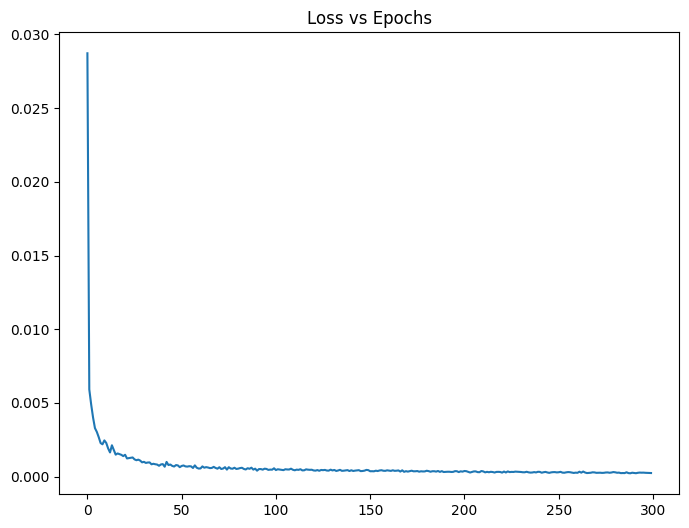

In [31]:
pd.DataFrame(result.history)['loss'].plot(title = "Loss vs Epochs", figsize = (8,6))

In [36]:
lstm_predicted_scaled = []
batch = scaled_test_data
current_batch = batch.reshape((1, n_input, n_features))
for i in range(len(test_data)):
    lstm_pred = model.predict(current_batch)[0]
    lstm_predicted_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:, 1: , :], [[lstm_pred]], axis = 1)

# scaler.inverse_transform - Inverse the transformed o/p from (0-1) to original data range
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predicted_scaled))
np.round(prediction)

1/1 [==============================] - 0s 21ms/step


,0
0,661816075.0
1,661841432.0
2,661837867.0
3,661800733.0
4,661731352.0
5,661634491.0
6,661515919.0
7,661381043.0
8,661233910.0
9,661077242.0
